In [1]:
import os,shutil

"""GPU设置为按需增长"""
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
# 指定第一块GPU可用
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
sess = tf.Session(config=config)
KTF.set_session(sess)

original_dataset_dir_female = '/home/wangtingshen/tingshen-code/female/'
original_dataset_dir_male = '/home/wangtingshen/tingshen-code/male/'

Using TensorFlow backend.


In [2]:
#保存较小的数据集
base_dir = '/home/wangtingshen/tingshen-code/real-dataset'

#拼接子路径，划分训练、验证、测试集
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir,'test')

#训练女性图像目录
train_female_dir = os.path.join(train_dir,'female')
#训练男性图像目录
train_male_dir = os.path.join(train_dir,'male')
#验证女性图像目录
validation_female_dir = os.path.join(validation_dir,'female')
#验证男性图像目录
validation_male_dir = os.path.join(validation_dir,'male')
#测试女性图像目录
test_female_dir = os.path.join(test_dir,'female')
#测试男性图像目录
test_male_dir = os.path.join(test_dir,'male')

print('total training female images:',len(os.listdir(train_female_dir)))
print('total training male images:',len(os.listdir(train_male_dir)))
print('total validation female images:',len(os.listdir(validation_female_dir)))
print('total validation male images:',len(os.listdir(validation_male_dir)))
print('total test female images:',len(os.listdir(test_female_dir)))
print('total test male images:',len(os.listdir(test_male_dir)))

total training female images: 70000
total training male images: 70000
total validation female images: 5000
total validation male images: 5000
total test female images: 5000
total test male images: 5000


In [3]:
from keras import models
from keras import layers

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#默认打乱数据
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224,224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224,224),
        batch_size=10,
        class_mode='binary')

Found 140000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [5]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 224, 224, 3)
labels batch shape: (20,)


In [6]:
import keras
from keras.applications.nasnet import NASNetLarge
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten
from keras.layers import Conv2D,MaxPool2D
from keras.utils import plot_model

# 定义输入
input_shape = (224,224,3) # RGB影像224x224（height,width,channel)
#引用模型
conv_base = NASNetLarge(weights=None, include_top=False, pooling='avg',input_shape=input_shape)
#conv_base.summary()

In [7]:
#定义模型
model = models.Sequential()
# 前馈全连接区块
model.add(conv_base)
model.add(Dense(1,activation='sigmoid',name='predictions'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 4032)              84916818  
_________________________________________________________________
predictions (Dense)          (None, 1)                 4033      
Total params: 84,920,851
Trainable params: 84,724,183
Non-trainable params: 196,668
_________________________________________________________________


In [8]:
from keras import optimizers
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
    initial_lr = 1e-4
    drop = 0.1
    epochs_drop = 15.0
    lrate = initial_lr*math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate

learning_rate = LearningRateScheduler(step_decay)
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=3500, #每个step表示1个batch_size的数据大小
        epochs=100,
        validation_data=validation_generator,
        callbacks=[learning_rate],
        validation_steps=1000)


Epoch 1/100
3500/3500 [==============================] - 2102s 601ms/step - loss: 0.2198 - acc: 0.9109 - val_loss: 6.5556 - val_acc: 0.5019
Epoch 2/100
3500/3500 [==============================] - 2012s 575ms/step - loss: 0.1048 - acc: 0.9601 - val_loss: 0.8723 - val_acc: 0.5029
Epoch 3/100
3500/3500 [==============================] - 1986s 568ms/step - loss: 0.0793 - acc: 0.9714 - val_loss: 0.8278 - val_acc: 0.5008
Epoch 4/100
3500/3500 [==============================] - 1985s 567ms/step - loss: 0.0762 - acc: 0.9720 - val_loss: 0.6819 - val_acc: 0.7668
Epoch 5/100
3500/3500 [==============================] - 1986s 567ms/step - loss: 0.0587 - acc: 0.9796 - val_loss: 1.5096e-06 - val_acc: 0.9436
Epoch 6/100
3500/3500 [==============================] - 1985s 567ms/step - loss: 0.0586 - acc: 0.9792 - val_loss: 2.5917e-15 - val_acc: 0.9502
Epoch 7/100
3500/3500 [==============================] - 1985s 567ms/step - loss: 0.0433 - acc: 0.9851 - val_loss: 4.1083e-21 - val_acc: 0.9593
Epoch 8

Epoch 56/100
3500/3500 [==============================] - 1999s 571ms/step - loss: 3.1499e-04 - acc: 1.0000 - val_loss: 3.4474 - val_acc: 0.9784
Epoch 57/100
3500/3500 [==============================] - 1999s 571ms/step - loss: 1.3230e-04 - acc: 1.0000 - val_loss: 3.9701e-09 - val_acc: 0.9784
Epoch 58/100
3500/3500 [==============================] - 1999s 571ms/step - loss: 3.4925e-04 - acc: 0.9999 - val_loss: 4.1438e-09 - val_acc: 0.9784
Epoch 59/100
3500/3500 [==============================] - 2000s 571ms/step - loss: 9.7845e-05 - acc: 1.0000 - val_loss: 4.0966e-09 - val_acc: 0.9784
Epoch 60/100
3500/3500 [==============================] - 2000s 571ms/step - loss: 3.3796e-04 - acc: 1.0000 - val_loss: 9.4790e-08 - val_acc: 0.9784
Epoch 61/100
3500/3500 [==============================] - 1999s 571ms/step - loss: 4.6143e-04 - acc: 0.9999 - val_loss: 4.5965e-08 - val_acc: 0.9784
Epoch 62/100
3500/3500 [==============================] - 2000s 571ms/step - loss: 1.5383e-04 - acc: 1.0000 - 

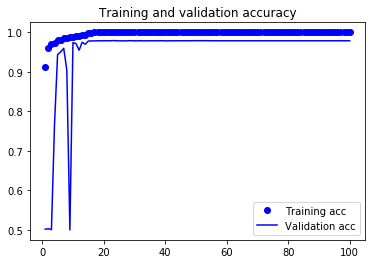

In [12]:
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

acc = history.history['acc']
val_acc =  history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

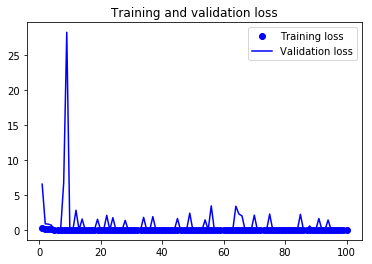

In [13]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()